In [5]:
import pandas as pd
import openpyxl
import xlsxwriter
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np

#Converting csv data
script_df = pd.read_csv('../../finance_vicky/files/input/Scripts_Data_Aug2017_Aug2018.csv')
#declaring nifty 50 index
nifty_50_pos = 72.48
nifty_50_neg = -58.18

In [6]:
#Cleaning up the data
#Setting_index, Creating a df for market cap, Dropping market_cap from script_df,
script_df.set_index('Script', inplace=True)
market_cap_df = pd.DataFrame({'Script': script_df.index.values, 'Market Cap': script_df['Market Cap'].values})
market_cap_df.set_index('Script', inplace=True)
script_df.drop(['Market Cap'], axis=1, inplace = True)
script_df.columns
script_df.columns = pd.to_datetime(script_df.columns)


In [7]:
#Taking care of blank values
#script_df.isnull().sum() ---> There are 251 places where stock values are missing
#Backward Filling for scripts that start with missing value.
no_value_start_scripts = script_df[script_df[script_df.columns[0]].isnull()].index
for i in no_value_start_scripts:
    first_valid_date = script_df.loc[i].first_valid_index()
    script_df.loc[i,script_df.columns[0]:first_valid_date] = script_df.loc[i, first_valid_date]
    #print(script_df.loc[i,script_df.columns[0]:first_valid_date])

#get scripts with intermittent missing values in between.
no_value_inbetw_scripts = script_df[script_df.isnull().any(axis=1)].index

#Interpolate and fill in the missing values
script_df.interpolate(method='linear',axis=1, inplace=True)
script_df = script_df.round(2)

In [8]:
#Calculating %change in values: %Data
#get a transponse of the dataframe 
t_script_df = script_df.T
t_pct_change_df = t_script_df.pct_change()*100
t_pct_change_df = t_pct_change_df.round(2)


In [9]:
#Aggregating +ve and -ve change
t_pct_change_net_df = pd.DataFrame(t_pct_change_df.sum(), columns=['Net']) 
t_pct_change_neg_df = pd.DataFrame(t_pct_change_df[t_pct_change_df[t_pct_change_df.columns] < 0.0].sum(), columns=['Negative'])
t_pct_change_pos_df = pd.DataFrame(t_pct_change_df[t_pct_change_df[t_pct_change_df.columns] > 0.0].sum(), columns=['Positive'])
t_pct_change_cal_df = pd.concat([t_pct_change_pos_df,t_pct_change_neg_df,t_pct_change_net_df, market_cap_df], axis = 1)


In [24]:
 #Printing
 #Transposed_Data
 writer = pd.ExcelWriter('transposed_script_data_Aug2017_Aug2018.xlsx', engine='xlsxwriter', datetime_format='mm/dd/yyyy',
                        date_format='mm/dd/yyyy')
 #writer = xlsxwriter.Workbook('transposed_script_data_Aug2017_Aug2018.xlsx')

 script_df.to_excel(writer,sheet_name='Data')
 t_pct_change_df.T.to_excel(writer,sheet_name='%Data')
 t_pct_change_cal_df.to_excel(writer, sheet_name='Sum of Positive & Negative')
 t_pct_change_pos_df.sort_values(by=['Positive'], ascending=False).to_excel(writer, sheet_name='Positive Sorting')
 t_pct_change_neg_df.sort_values(by=['Negative'], ascending=False).to_excel(writer, sheet_name='Negative Sorting')
 writer.save()
 

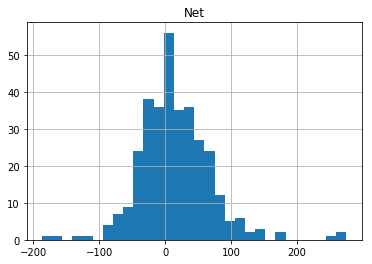

In [11]:
t_pct_change_net_df.hist(bins=30)
plt.show()